![alt text](network_simple.png)

![alt text](network.png)

In [2]:
# need to install: 
# pip install "gymnasium[atari,accept-rom-license]"

import numpy as np
import matplotlib.pyplot as plt
import pickle
# import gym
import gymnasium as gym
import ale_py


In [3]:
gym.register_envs(ale_py) 

In [8]:
env = gym.make("ALE/Pong-v5", render_mode="human")
observation, info = env.reset()

# does not work in notebok
env.render()

#print(observation)

In [ ]:
observation

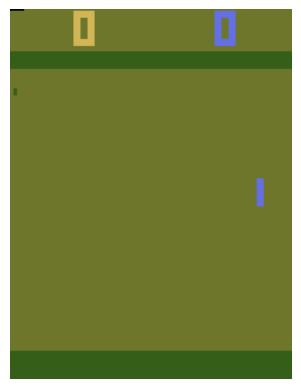

In [10]:
# to render in Jupyter Notebook
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")  # Use "rgb_array" for Jupyter
observation, info = env.reset()

# Render the first frame
frame = env.render()  # Returns an image (RGB array)

# Display the frame using Matplotlib
plt.imshow(frame)
plt.axis("off")  # Hide axes
plt.show()

env.close()


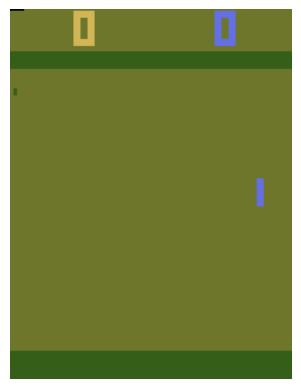

In [11]:
plt.imshow(observation)
plt.axis("off")  # Hide axes
plt.show()

In [12]:
print(observation.shape)
# (210, 160, 3)

pixel0 =  observation[10, 10]
print(pixel0)
# r, g, b
#[109 118  43]


(210, 160, 3)
[109 118  43]


(160, 160, 3)


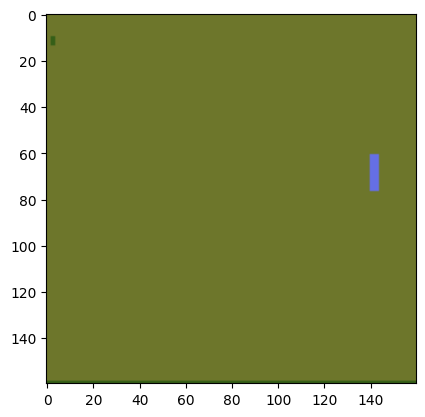

In [13]:
cropped  = observation[35:195]

print(cropped.shape)
#(160, 160, 3)

plt.imshow(cropped)

(80, 80)


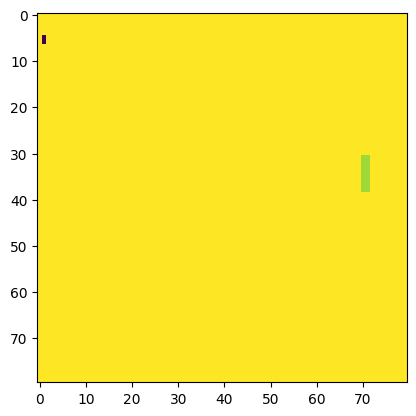

In [14]:
sampled = cropped[::2, ::2, 0]

print(sampled.shape)
#(80, 80)

plt.imshow(sampled)

(80, 80)


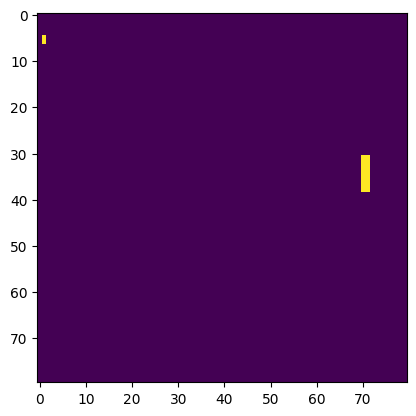

In [15]:
sampled[sampled == 144] = 0
sampled[sampled == 109] = 0
sampled[sampled != 0] = 1
print(sampled.shape)
plt.imshow(sampled)

In [16]:
sampled = sampled.astype(float).ravel()
print(sampled.shape)
# (6400,)

(6400,)


In [17]:
sampled

array([0., 0., 0., ..., 0., 0., 0.], shape=(6400,))

In [12]:
drs = [0, 0, 0, 1, 0, 0, -1, 0]
epr = np.vstack(drs)
print(epr)

print(epr.shape)
# (8, 1)


[[ 0]
 [ 0]
 [ 0]
 [ 1]
 [ 0]
 [ 0]
 [-1]
 [ 0]]
(8, 1)


In [19]:
def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

In [20]:
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

In [22]:
D = 80 * 80 # input dimensionality: 80x80 grid
model = {}
model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
model['W2'] = np.random.randn(H) / np.sqrt(H)

In [23]:
def policy_forward(x):
  # np.dot(W1, x) multiplies each row of the matrix W1 with the vector x to produce a new vector h of length H.
  # Each element in h is a weighted sum of the elements in x, where the weights are the elements of the corresponding row in W1.
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity

  # np.dot(W2, h) multiplies the vector W2 with the vector h to produce a scalar logp.
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

In [24]:
# Define a 3x4 weight matrix (W1)
W1 = np.array([[1, 2, 3, 4],
               [5, 6, 7, 8],
               [9, 10, 11, 12]])

# Define a 4-dimensional input vector (x)
x = np.array([1, 2, 3, 4])

h = np.dot(W1, x)
print(h)

r1 = 1*1 + 2*2 + 3*3 + 4*4
print(r1)


[ 30  70 110]
30


In [23]:
# Define a 3x4 weight matrix (W1)
W1 = np.array([[1, 2, 3, 4],
               [5, 6, 7, 8],
               [9, 10, 11, 12]])

# Define a 4-dimensional input vector (x)
x = np.array([1, 2, 3, 4])

x = np.vstack(x)
print(x)

h = np.dot(W1, x)
print(h)

r1 = 1*1 + 2*2 + 3*3 + 4*4
print(r1)


[[1]
 [2]
 [3]
 [4]]
[[ 30]
 [ 70]
 [110]]
30


In [ ]:
def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """

  # (1005,1)
  print(epdlogp.shape)

  # (1005, 200)
  print(eph.shape)

  # (200, 1005)
  print((eph.T).shape)
  
  dW2 = np.dot(eph.T, epdlogp).ravel()
  # (200,)
  print(dW2.shape)  

  dh = np.outer(epdlogp, model['W2'])
  #(1005, 200)
  print(dh.shape)


  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  # (200, 6400)
  print(dW1.shape)


  return {'W1':dW1, 'W2':dW2}

dW2 = np.dot(eph.T, epdlogp).ravel()
|           | $ \text{action}_0 $ | $ \text{action}_1 $ | $ \text{action}_2 $ | $ \text{action}_3 $ | ... | $ \sum $ |
|-----------|------------------------|------------------------|------------------------|------------------------|-----|-----|
| $ dW_2^0 $   | $ h_0^0 \cdot d\text{logit}_0 $ | $ h_0^1 \cdot d\text{logit}_1 $ | $ h_0^2 \cdot d\text{logit}_2 $ | ... | ... | $ h_0^0 \cdot d\text{logit}_0+h_0^1 \cdot d\text{logit}_1+\dots $ |
| $ dW_2^1 $   | $ h_1^0 \cdot d\text{logit}_0 $ | $ h_1^1 \cdot d\text{logit}_1 $ | $ h_1^2 \cdot d\text{logit}_2 $ | ... | ... | $ h_1^0 \cdot d\text{logit}_0+h_1^1 \cdot d\text{logit}_1+\dots $ |
| $ \vdots $   | ... | ... | ... | ... | ... | ... |
| $ dW_2^{200} $ | ... | ... | ... | ... | ... | ... |

dh.T

|           | $ \text{action}_0 $ | $ \text{action}_1 $ | $ \text{action}_2 $ | $ \text{action}_3 $ | ... | 
|-----------|------------------------|------------------------|------------------------|------------------------|-----|
| $ dh_0 $   | $ dh_0^0 $ | $ dh_0^1 $ | ... | ... | ... | 
| $ dh_1 $   | $ dh_1^0 $ | $ dh_1^1 $ | ... | ... | ... | 
| $ \vdots $   | ... | ... | ... | ... | ... |
| $ dh_{200} $   | $ dh_{200}^0 $ | $ dh_{200}^1 $ | ... | ... | ... |

epx:

|           | $ x_0 $ | $ x_1 $ | ... | ... | $ x_{6399} $ |  
|-----------|------------------------|------------------------|------------------------|------------------------|-----|  
| $ action_0 $   | $ x_0^0 $ | $ x_1^0 $ | ... | ... | $ x_{6399}^0 $ |  
| $ action_1 $   | $ x_0^1 $ | $ x_1^1 $ | ... | ... | $ x_{6399}^1 $ |  
| $ \vdots $   | ... | ... | ... | ... | ... |  
| $ \text{action}_{1005} $   | ... | ... | ... | ... | ... | 

dW1 = np.dot(dh.T, epx)

|           | $ x_0 $ | $ x_1 $ | ... | $ x_{6399} $ |  
|-----------|--------|--------|-----|-------------|  
| $ dh_0 $   | $ \sum_{k} dh_{0,k} x_{k,0} $ | $ \sum_{k} dh_{0,k} x_{k,1} $ | ... | $ \sum_{k} dh_{0,k} x_{k,6399} $ |  
| $ dh_1 $   | $ \sum_{k} dh_{1,k} x_{k,0} $ | $ \sum_{k} dh_{1,k} x_{k,1} $ | ... | $ \sum_{k} dh_{1,k} x_{k,6399} $ |  
| $ \vdots $   | ... | ... | ... | ... |  
| $ dh_{199} $ | $ \sum_{k} dh_{199,k} x_{k,0} $ | $ \sum_{k} dh_{199,k} x_{k,1} $ | ... | $ \sum_{k} dh_{199,k} x_{k,6399} $ |  



In [25]:
import numpy as np

# Create a 1D array with numbers 1 through 11.
dlogit = np.arange(1, 12)  
print("Original dlogit (1D):")
print(dlogit)       # Output: [ 1  2  3  ... 11]
print("Shape:", dlogit.shape)  # (11,)

# Convert dlogit into a 2D column vector of shape (11, 1)
dlogit = np.vstack(dlogit)
print("\ndlogit after vstack (2D column vector):")
print(dlogit)
print("Shape:", dlogit.shape)  # (11, 1)

# Define eph with specific values (1, 2, 3, 4 repeated across rows)
eph = np.array([[1, 2, 3, 4]] * 11)  # 11 rows, each with [1, 2, 3, 4]
print("\neph (specific values):")
print(eph)

print("\neph.T:", eph.T)

# Compute the dot product
dW2 = np.dot(eph.T, dlogit)
print("\ndW2 (dot product of eph.T and dlogit):")
print(dW2)



Original dlogit (1D):
[ 1  2  3  4  5  6  7  8  9 10 11]
Shape: (11,)

dlogit after vstack (2D column vector):
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]]
Shape: (11, 1)

eph (specific values):
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]

eph.T: [[1 1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4 4]]

dW2 (dot product of eph.T and dlogit):
[[ 66]
 [132]
 [198]
 [264]]


In [ ]:
# Verify how outer works

import numpy as np

# Create a 1D array with numbers 1 through 11.
dlogit = np.arange(1, 12)  
print("Original dlogit (1D):")
print(dlogit)       # Output: [ 1  2  3  ... 11]
print("Shape:", dlogit.shape)  # (11,)

# Convert dlogit into a 2D column vector of shape (11, 1)
dlogit = np.vstack(dlogit)
print("\ndlogit after vstack (2D column vector):")
print(dlogit)
print("Shape:", dlogit.shape)  # (11, 1)

# Create a 1D array W2 with numbers 1, 2, 3, 4.
W2 = np.array([1, 2, 3, 4])
print("\nW2:")
print(W2)
print("Shape:", W2.shape)  # (4,)

# Compute the outer product of dlogit and W2.
dh = np.outer(dlogit, W2)
print("\ndh (outer product of dlogit and W2):")
print(dh)
print("Shape:", dh.shape)  # (11, 4)


Original dlogit (1D):
[ 1  2  3  4  5  6  7  8  9 10 11]
Shape: (11,)

dlogit after vstack (2D column vector):
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]]
Shape: (11, 1)

W2:
[1 2 3 4]
Shape: (4,)

dh (outer product of dlogit and W2):
[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]
 [ 4  8 12 16]
 [ 5 10 15 20]
 [ 6 12 18 24]
 [ 7 14 21 28]
 [ 8 16 24 32]
 [ 9 18 27 36]
 [10 20 30 40]
 [11 22 33 44]]
Shape: (11, 4)
